# Simulating retention rate over time

## Background

I reconnected with a friend of mine from high school last week. It was the first time we had seen each other in over 10 years. Writing that tempts me to wax poetic about the bizarre flow of time (it goes fast). The goal of my post is not to pontificate on the undulations of our lives but rather to do analysis. 

Here is the situation: my friend started a new job teaching music lessons a few months ago, and she asked me to help her with a problem she was having. One of the KPIs, or Key Performance Indicators for people who have not worked in a cubicle, her managers use to assess their employees is called *retention rate*. They measure retention each week by dividing the number of students who return to class the following week by the number of students who attended the class the previous week. They take a moving average of this rate and use it to decide what to pay their employees. Having only been at the company for a few months, she wondered if her short tenure had to do with her low retention rate. The hypothesis was that working at the same place for longer would let the instructor build up a portfolio of 'dedicated students'. When the tutor's portfolio consists almost entirely of dedicated students, the students are less likely to churn, thus making retention high.

We therefore theorized that retention should naturally increase over time, but we weren't sure if we were right or by how much. In this notebook, I plug in a few student retention probabilities and simulate the retention rate over time. I do this over multiple runs to see if, holding all else constant, the retention rate naturally increases over time or not.

There are a couple of variables I define in this notebook to help with the basic simulations.
- `p_good_student`: The probability that a new student is motivated. Good students have a higher probability of returning the following week.
- `p_retention_good`: The probability that a good student will return the following week.
- `p_retention_bad`: The probability that a bad student will return the following week.
- `new_students_per_week`: The number of new students that join the class each week.
- `maximum_students_in_portfolio`: The maximum number of students a teacher can have in a given week.
- `weeks`: The number of weeks to simulate.



### Step 1: Define a small dataclass
Below I define a student who only has one attribute: their probability of retention. In the simulation, good students get a higher probability of retention than bad students.

In [1]:
from dataclasses import dataclass
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

font = {'size': 20}

matplotlib.rc('font', **font)

@dataclass
class Student:
    """A student in the class.

    Returns
    -------
    Student
        A student in the class. The student has a probability of being retained.
    """

    p_retained: float

    def is_retained(self) -> float:
        """Returns whether the student is retained in a given week."""
        return np.random.rand() < self.p_retained

### 2. Define helper functions for our simulation
Next I define a helper function to build all the students who join the class each week, where some are good and some are bad. 

I further define my function to simulate retention week by week.

In [2]:
def create_new_students(
    p_good_student: float,
    p_retention_good: float,
    p_retention_bad: float,
    new_students_per_week: int,
) -> List[Student]:
    """
    Get the students for a week
    """
    return [
        Student(
            p_retained=(
                p_retention_good
                if np.random.rand() < p_good_student
                else p_retention_bad
            )
        )
        for _ in range(new_students_per_week)
    ]


def simulate_retention(
    n_weeks: int,
    p_good_student: float,
    p_retention_good: float,
    p_retention_bad: float,
    new_students_per_week: int,
    maximum_students: int,
) -> pd.DataFrame:
    """Simulate student retention over time.

    Parameters
    ----------
    n_weeks : int
        Number of weeks to simulate.
    p_good_student : float
        Probability of a new student being motivated.
    p_retention_good : float
        Probability of a motivated student being retained.
    p_retention_bad : float
        Probability of a not motivated student being retained.
    new_students_per_week : int
        Number of new students per week.

    Returns
    -------
    pd.DataFrame
        A dataframe with relevant outputs of the experiment.
    """

    data = pd.DataFrame(
        {
            "week": np.arange(n_weeks),
            "new_students": np.zeros(n_weeks),
            "students_start_of_week": np.zeros(n_weeks),
            "students_who_come_back_next_week": np.zeros(n_weeks),
            "n_lost": np.zeros(n_weeks),
            "retention_rate": np.zeros(n_weeks),
        }
    ).assign(new_students = lambda x: x.new_students.astype(int))
    # Initialize first week
    data.loc[0, "new_students"] = new_students_per_week

    start_week_student_list = []

    # Simulate retention
    for i in range(n_weeks):
        new_students = data.loc[i, "new_students"]
        start_week_student_list += create_new_students(
            p_good_student, p_retention_good, p_retention_bad, new_students
        )
        data.loc[i, "students_start_of_week"] = len(start_week_student_list)

        end_week_student_list = []
        for student in start_week_student_list:
            if student.is_retained():
                end_week_student_list.append(student)

        n_lost = len(start_week_student_list) - len(end_week_student_list)
        start_week_student_list = end_week_student_list.copy()

        data.loc[i, "students_who_come_back_next_week"] = len(end_week_student_list)
        data.loc[i + 1, "new_students"] = min(
            maximum_students - len(end_week_student_list), new_students_per_week
        )
        data.loc[i, "n_lost"] = n_lost

        # Calculate retention rate
        data.loc[i, "retention_rate"] = (
            data.loc[i, "students_who_come_back_next_week"]
            / data.loc[i, "students_start_of_week"]
        )
        data.loc[i, "moving_average_retention_rate"] = (
            data.loc[:i, "retention_rate"]
            .rolling(window=5, center=False)
            .mean()
            .iloc[-1]
        )

    return data

## 3. Plot a few simulations and observe

Below I run four simulations over 52 weeks and plot the results, highlighting the moving average retention. Coinciding with the hypothesis that retention rate should increase over time, we see that three out of four charts below increase for the parameters I set, at least in the first few weeks. Interestingly none of them level off and remain steady. Some even drop down over time, sometimes substantially, due to the randomness of the simulation. Ceteris paribus, weekly retention is a highly variable measure, even averaged over time.

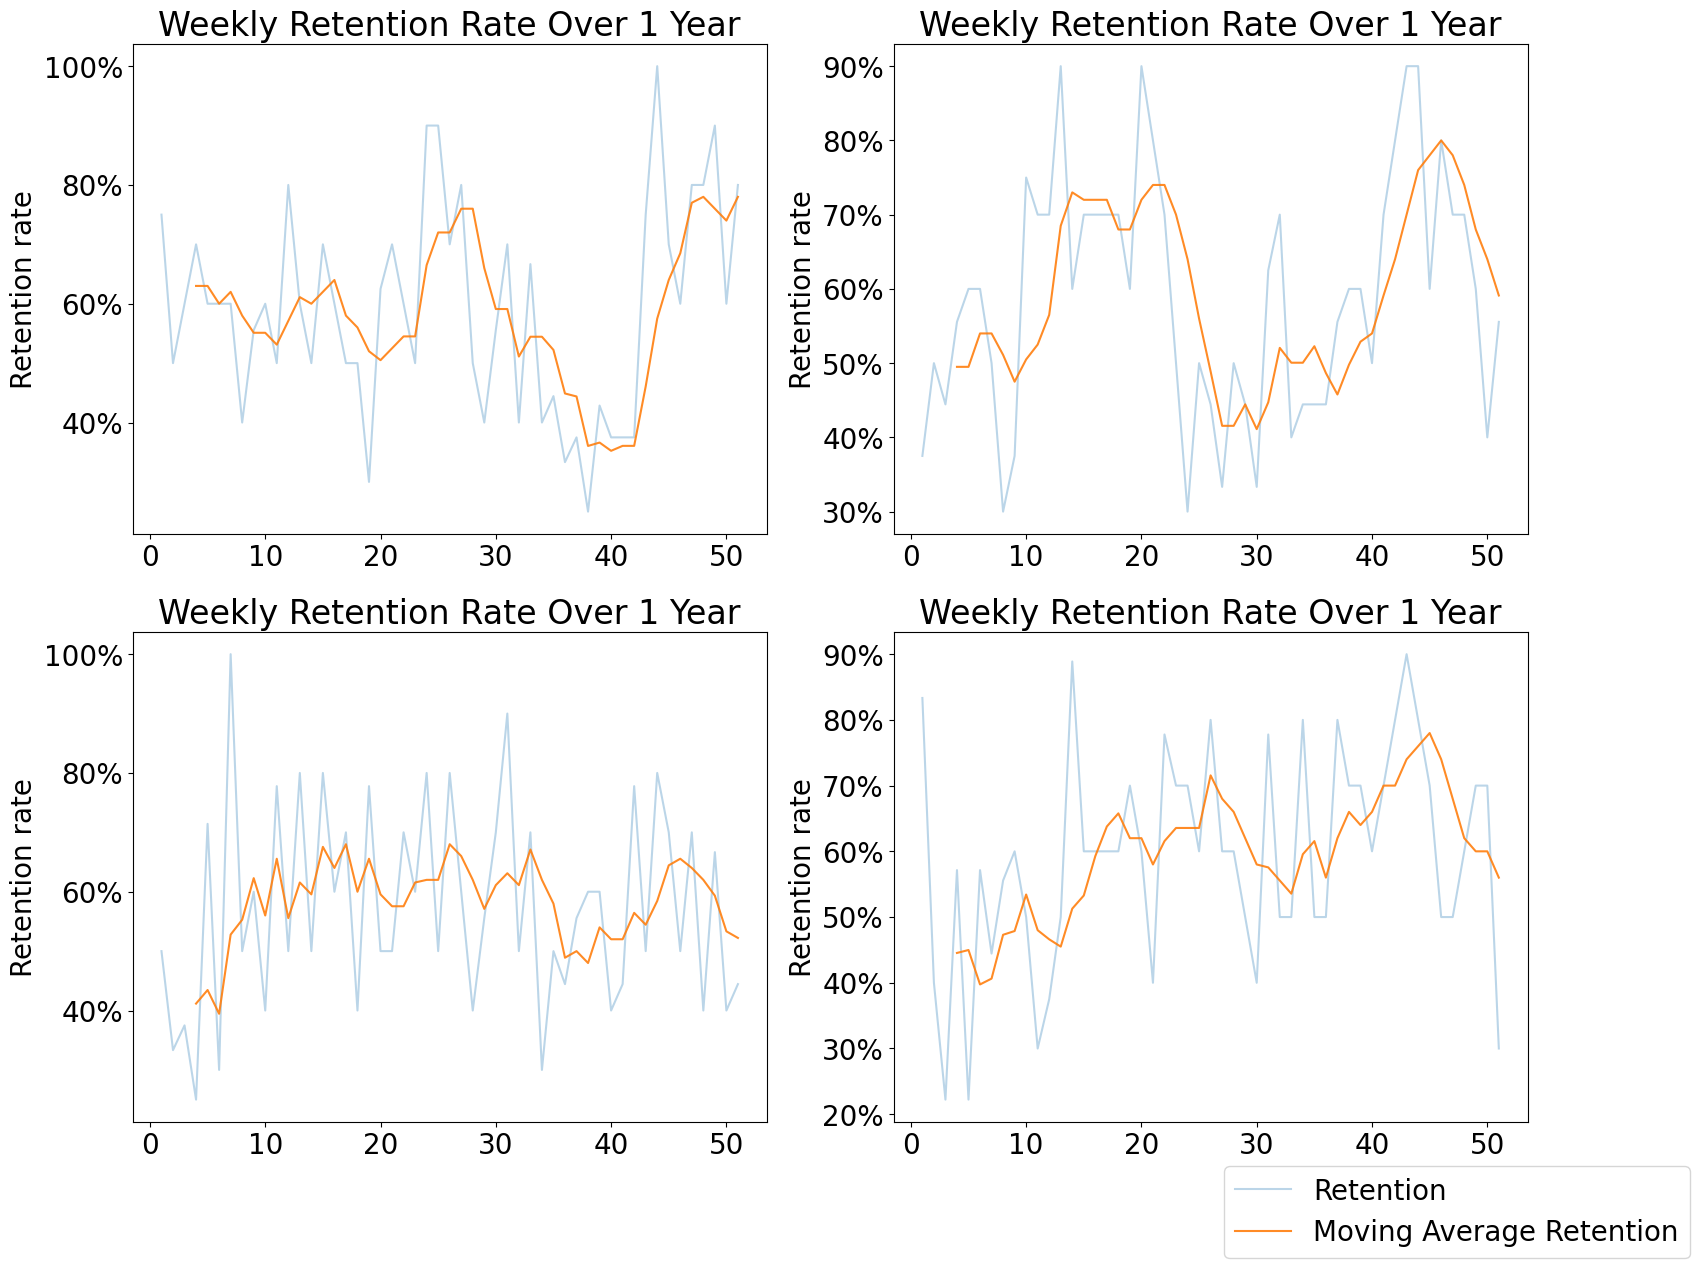

In [8]:
from itertools import product

# Parameters
P_GOOD_STUDENT = 0.3  # probability of a good student
P_RETENTION_GOOD = 0.8  # probability of retention for good students
P_RETENTION_BAD = 0.3  # probability of retention for bad students
NEW_STUDENTS_PER_WEEK = 5  # number of new students per week
MAXIMUM_STUDENTS = 10  # maximum number of students a teacher can have in a given week
N_WEEKS = 52  # number of weeks to simulate


def plot_retention(ax, data):
    data = data.copy().iloc[1:]
    ax.plot(data["week"], data["retention_rate"], label="Retention rate", alpha=0.3)
    ax.plot(
        data["week"],
        data["moving_average_retention_rate"],
        label="Moving average retention rate",
        alpha=0.9,
    )
    ax.set_xlabel("")
    ax.set_ylabel("Retention rate")
    # Format y as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))
    ax.set_title("Weekly Retention Rate Over 1 Year")


fig, ax = plt.subplots(2, 2, figsize=(18, 14))

np.random.seed(42)
for i, j in product(range(2), range(2)):
    sim_data = simulate_retention(
        N_WEEKS,
        P_GOOD_STUDENT,
        P_RETENTION_GOOD,
        P_RETENTION_BAD,
        NEW_STUDENTS_PER_WEEK,
        MAXIMUM_STUDENTS,
    )
    plot_retention(ax[i, j], sim_data)
fig.legend(["Retention", "Moving Average Retention"], loc="lower right")
plt.savefig("images/four_simulations.png")

![initial_simulations](images/four_simulations.png)

### 4. Make lots of simulations
Since the original simulation was so variable, I thought it would help to run more simulations so that I could see the average and standard deviation of the retention rate over time. I plot the average and standard deviation of the retention rate over time. In the initial parameters I set, the retention rate increases by roughly 10% in the first 10 weeks. Noting the variability observed above we can see the standard deviation is fairly far from the average. For example, a moving average retention rate of 60% is expected to vary between 50% and 70% within 1 standard deviation.

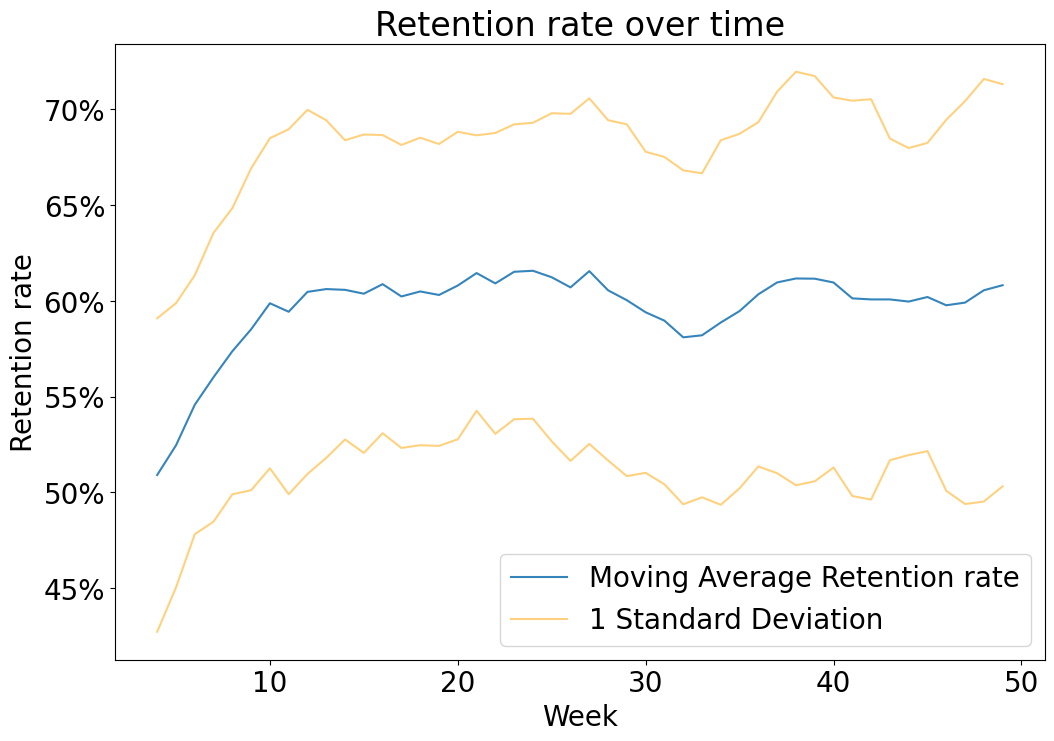

In [14]:

def simulate_multiple_runs(
    n_runs: int,
    n_weeks: int,
    p_good_student: float,
    p_retention_good: float,
    p_retention_bad: float,
    new_students_per_week: float,
    maximum_students: int,
):
    all_data = []
    for i in range(n_runs):
        data = simulate_retention(
            n_weeks,
            p_good_student,
            p_retention_good,
            p_retention_bad,
            new_students_per_week,
            maximum_students,
        )
        data["run"] = i
        all_data.append(data)

    all_data = (
        pd.concat(all_data)
        .groupby("week")
        .agg(
            {
                "retention_rate": ["mean", "std"],
                "moving_average_retention_rate": ["mean", "std"],
            }
        )
        .reset_index()
    )
    all_data.columns = list(map("_".join, all_data.columns.values))
    all_data = all_data.rename(columns={"week_": "week"})
    return all_data


## Plot the output
def plot_simulations(data):
    fig, ax = plt.subplots(figsize=(12, 8))
    data = data.copy().iloc[1:]
    upper_stdev = data["moving_average_retention_rate_mean"] + (
        data["moving_average_retention_rate_std"]
    )
    lower_stdev = data["moving_average_retention_rate_mean"] - (
        data["moving_average_retention_rate_std"]
    )
    ax.plot(
        data["week"],
        data["moving_average_retention_rate_mean"],
        label="Moving Average Retention rate",
        alpha=0.9,
    )
    ax.plot(
        data["week"],
        lower_stdev,
        label="1 Standard Deviation",
        alpha=0.5,
        color="orange",
    )
    ax.plot(data["week"], upper_stdev, label="", alpha=0.5, color="orange")
    ax.set_xlabel("Week")
    ax.set_ylabel("Retention rate")
    # Format y as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))
    ax.set_title(("Retention rate over time"))
    ax.legend()
    plt.savefig("images/aggregate_simulation.png")
    plt.show()


# Parameters
P_GOOD_STUDENT = 0.3  # probability of a good student
P_RETENTION_GOOD = 0.8  # probability of retention for good students
P_RETENTION_BAD = 0.3  # probability of retention for bad students
NEW_STUDENTS_PER_WEEK = 5  # number of new students per week
MAXIMUM_STUDENTS = 10  # maximum number of students a teacher can have in a given week
N_WEEKS = 50  # number of weeks to simulateRun Data

np.random.seed(42)
all_sim_data = simulate_multiple_runs(
    50,
    N_WEEKS,
    P_GOOD_STUDENT,
    P_RETENTION_GOOD,
    P_RETENTION_BAD,
    NEW_STUDENTS_PER_WEEK,
    MAXIMUM_STUDENTS,
)
all_sim_data

plot_simulations(all_sim_data)

![aggregate_simulation](images/aggregate_simulation.png)

### 5. Make lots of simulations again but try some different parameters.

Our graph above is derived based on assumptions (This whole notebook is a mess of random assumptions). Still, it is worth seeing how the chart varies with some different scenarios in mind. I don't feel like grid searching across more than two dimensions, so I'll add four scenarios and give them each a name. Then I define one more function for plotting my results.

In [10]:
parameters = [
    {
        "situation": "More good students",
        "p_good_student": 0.6,
        "p_retention_good": 0.8,
        "p_retention_bad": 0.3,
        "new_students_per_week": 5,
    },
    {
        "situation": "Good students are really dedicated",
        "p_good_student": 0.3,
        "p_retention_good": 0.95,
        "p_retention_bad": 0.3,
        "new_students_per_week": 5,
    },
    {
        "situation": "Bad students aren't so bad",
        "p_good_student": 0.3,
        "p_retention_good": 0.8,
        "p_retention_bad": 0.5,
        "new_students_per_week": 5,
    },
    {
        "situation": "Less new students per week",
        "p_good_student": 0.3,
        "p_retention_good": 0.8,
        "p_retention_bad": 0.3,
        "new_students_per_week": 2,
    },
]



In [11]:
def plot_averaged_simulation(data: pd.DataFrame, ax: plt.Axes, label: str):
    data = data.copy().iloc[1:]
    upper_stdev = data["moving_average_retention_rate_mean"] + (
        data["moving_average_retention_rate_std"]
    )
    lower_stdev = data["moving_average_retention_rate_mean"] - (
        data["moving_average_retention_rate_std"]
    )
    ax.plot(
        data["week"],
        data["moving_average_retention_rate_mean"],
        label="Moving Average Retention rate",
        alpha=0.9,
    )
    ax.plot(
        data["week"],
        lower_stdev,
        label="1 Standard Deviation",
        alpha=0.5,
        color="orange",
    )
    ax.plot(data["week"], upper_stdev, label="", alpha=0.5, color="orange")
    ax.set_xlabel("")
    ax.set_ylabel("Retention rate")
    ax.set_ylim(0.25, 1)
    # Format y as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.0%}".format(x)))
    ax.set_title(label)

In all four scenarios, averaged across 50 runs, the general outcome is the same: moving average retention increases over time before leveling off. How that trend shows itself is different though not completely surprising across all of the parameters.
- More good students: The retention rate levels off in half the time.
- Good students are really dedicated: The retention rate levels off at a much higher level over more time and stays high. In this scenario, tenure has the greatest impact on retention rate. This scenario feels like the most realistic one to me. At a 95% change of staying each week, we can do the math and find that after 14 iterations, about half of really dedicated students leave, which feels fair. 
- Bad students aren't so bad: The retention rate doesn't increase much over (e.g. it matters less what your portolio consists of).
- Less new students per week: The retention rate levels off more slowly.

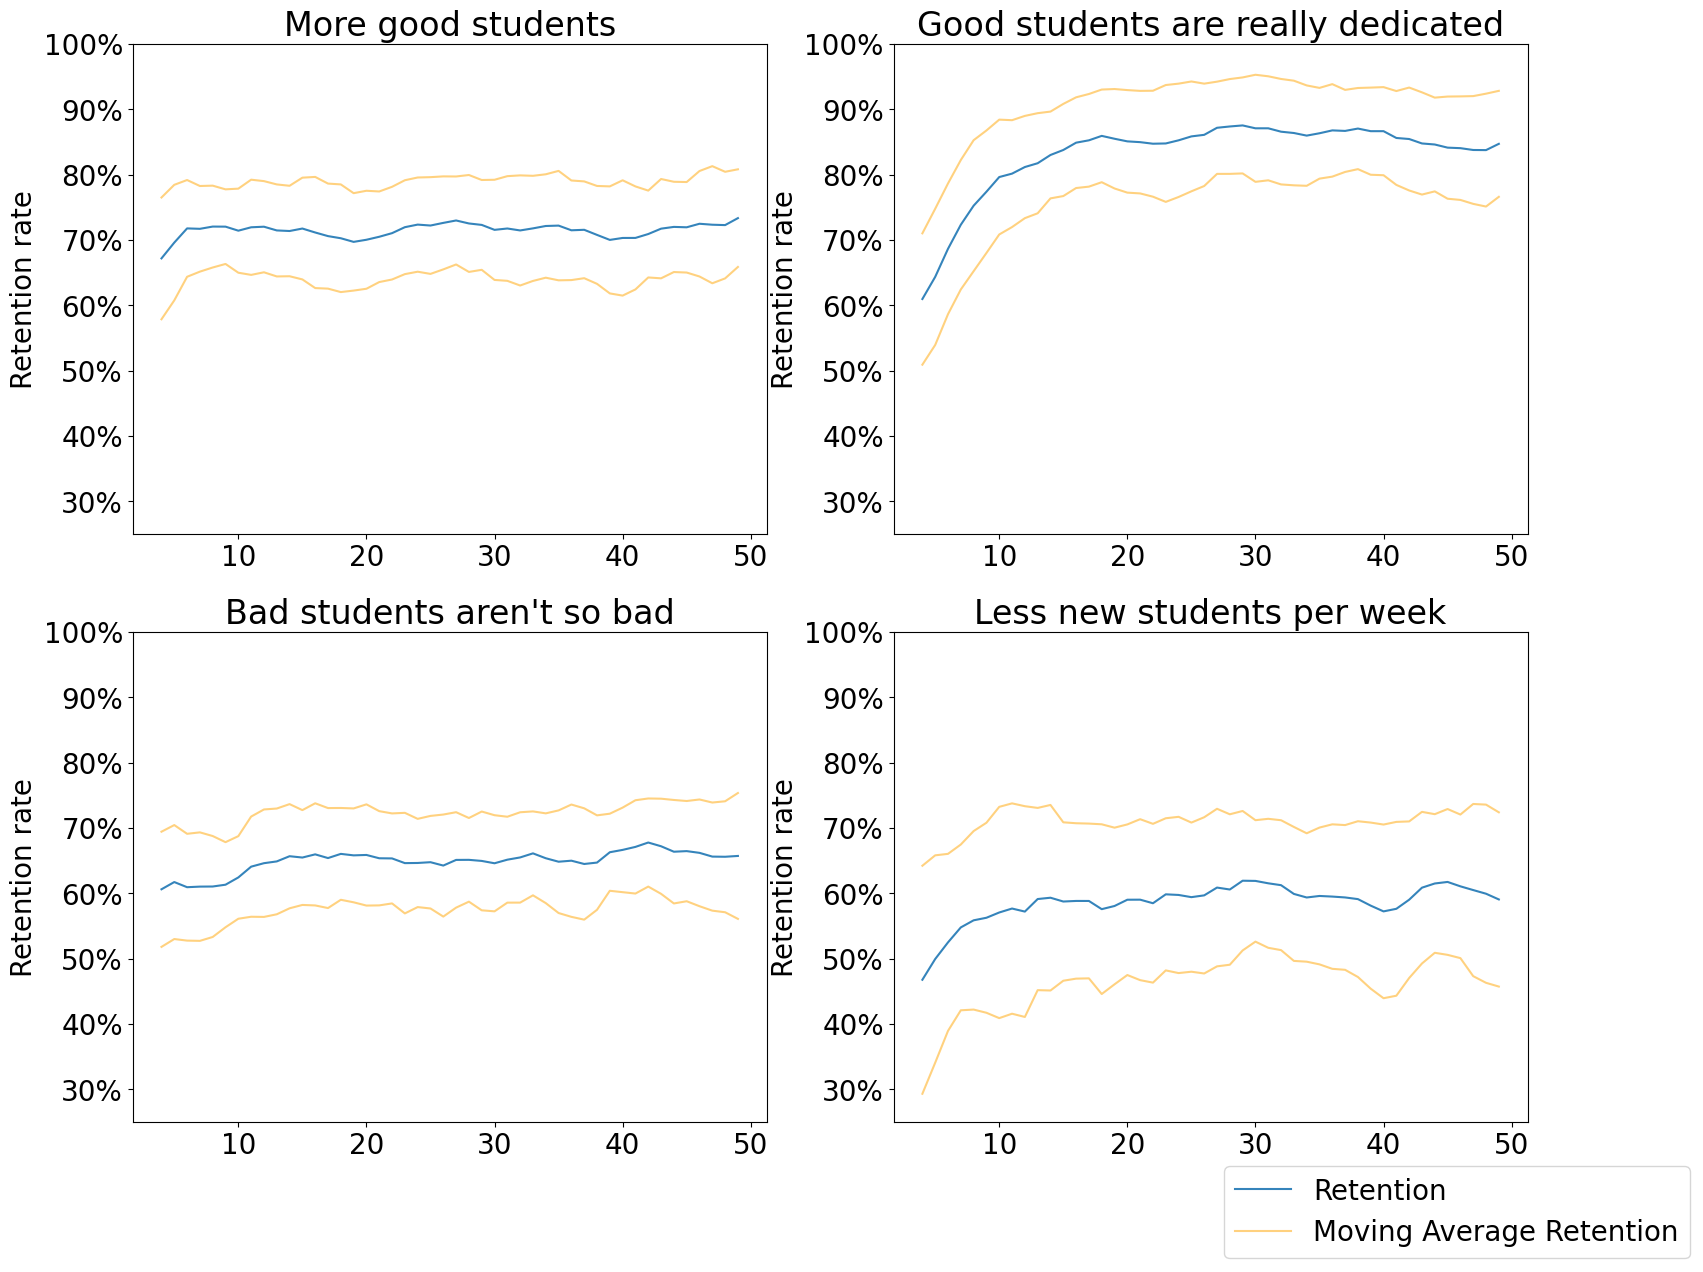

In [13]:
np.random.seed(42)
MAXIMUM_STUDENTS = 10  # maximum number of students a teacher can have in a given week
N_WEEKS = 50  # number of weeks to simulate
N_RUNS = 50  # number of runs to simulate

fig, ax = plt.subplots(2, 2, figsize=(18, 14))

for i, j in product(range(2), range(2)):
    simulation_number = i * 2 + j
    simulation_parameters = parameters[simulation_number].copy()
    scenario = simulation_parameters.pop("situation")
    sim_data = simulate_multiple_runs(
        n_runs=N_RUNS,
        n_weeks=N_WEEKS,
        maximum_students=MAXIMUM_STUDENTS,
        **simulation_parameters
    )
    plot_averaged_simulation(sim_data, ax[i, j], label=scenario)
fig.legend(["Retention", "Moving Average Retention"], loc="lower right")
plt.savefig("images/four_aggregate_simulations.png")

![aggregate_simulations](images/four_aggregate_simulations.png)

### Conclusion:

From the above simulations I make two suggestions:

1. Don't pay people based on weekly moving average retention within their first few months at your company. Across lots of instructors who somehow manage to change nothing in the way they teach, retention rate does indeed increase over time **on average**. Holding all else equal, this simply arises from the build up of more dedicated students in a teacher's portfolio. The increase is more pronounced the more likely a dedicated student is to stay week by week.
2. Maybe don't evaluate people by weekly moving average retention at all. Expected variability in retention is super high (look at the blue lines in the first charts I made). The simple fact that some students come to just try out a class and some come with the intention of staying makes it hard to properly assess a single teacher's performance even if some are better at retaining students than others.

I'll also end with an observation that none of the findings are incredibly surprising. Yet I imagine that this is not the only company who uses retention rate as a Key Performance Indicator for employee effectiveness. While I recognize the difficulty inherent in making data driven decisions on how you measure (and pay) your employees, I hope this notebook gives a few people pause before they make decisions based on retention rate alone.